# Spiking-Phasor VSA: Integrator
Purpose: to have a spiking-phasor SSP integrate its input.

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm
from phasorutils import *
from brian2 import *
from spikingVSA import *
from copy import deepcopy

## Integrator

### Single neuron

In [2]:
N = 1
freq = 10.
ϕ = 0.05
S = array([exp(ϕ*2.j*pi)])

net = SpikingPhasorNet()

inp = GenerateSP(N=N, C=S, freq=freq); net.add_pop(inp)
y = SPIntegrator(N=N, freq=freq); net.add_pop(y)

net.integrate(inp, y)

In [3]:
defaultclock.dt = 1.*ms

In [4]:
net.run(2*second)

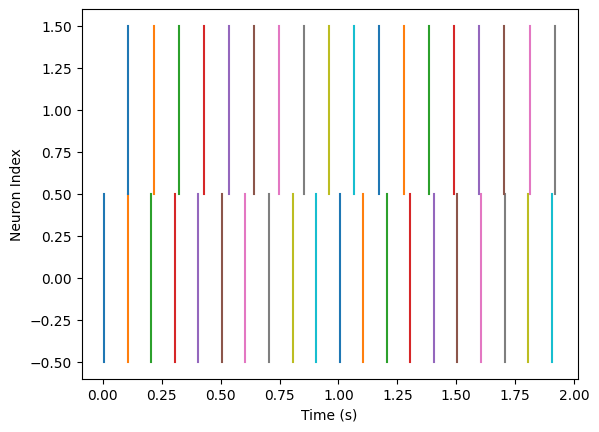

In [5]:
net.spike_raster()

## Integrating dynamic velocity

### Velocity function (and distance)

In [6]:
def vel_param(t, c, pause):
    L = 7.
    v = zeros_like(t)
    mask = t>=pause
    v = c[0]*sin((t-pause)*2*pi/L) * mask
    for k,cc in enumerate(c[1:]):
        v += cc*sin(2*k*(t-pause)*2*pi/L) * mask
    return array(v)

In [7]:
def dist(velo, ttvals):
    dt = ttvals[1] - ttvals[0]
    velocity = velo(ttvals)
    d = [0.]
    for vv in velocity[:-1]:
        d.append(d[-1]+vv*dt)
    return array(d)

In [8]:
freq = 10.
T = 5.  # simulation time

ttvals = arange(0, T, 1./freq/10.)

c = random.normal(size=(5,))
print(c)
vel = lambda t: vel_param(t,c,0.1)

[-1.57849138 -0.2958796   0.30012983  0.17428799 -0.60127615]


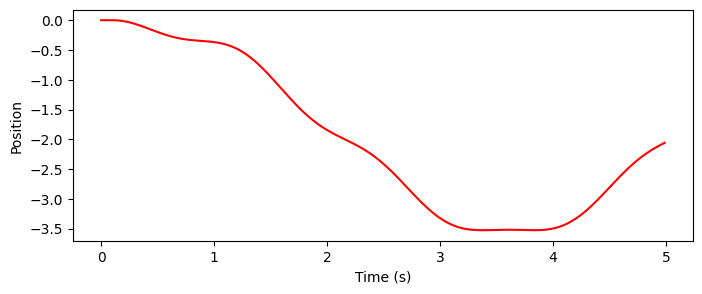

In [9]:
figure(figsize=(8,3))
plot(ttvals, dist(vel, ttvals), 'r');
xlabel('Time (s)'); ylabel('Position');
#savefig('position.pdf');

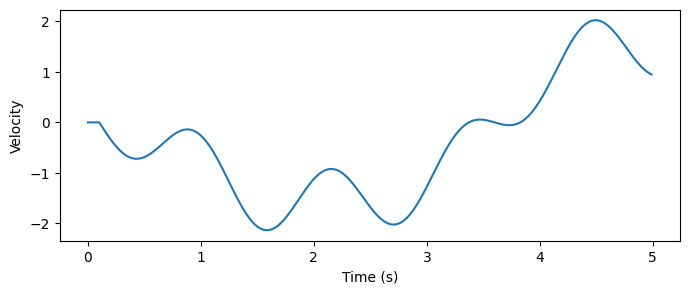

In [10]:
figure(figsize=(8,3))
plot(ttvals, vel(ttvals));
xlabel('Time (s)'); ylabel('Velocity');
#savefig('velocity.pdf');

### Integrate the velocity

In [11]:
N = 200   # dimension of hypervectors
reset_time = 0.1
v = 0.  # set a placeholder velocity
ds = SparsePhaseMap(M=1, N=N, sparsity=1.)

net = SpikingPhasorNet()

# Input velocity
# inp is the hypervector for encoding velocity and position
inp = GenerateSP(N=N, C=ds.S[0], freq=freq); net.add_pop(inp)

# Fractional binding of inp to encode velocity
V = PhaseMultPop(N=N, freq=freq); net.add_pop(V)
net.fractional_bind(inp, V, v/freq)

# Integrator population
y = SPIntegrator(N=N, freq=freq); net.add_pop(y)
net.integrate(V, y)  # y integrates V

# The reset neuron sends a single spike at t=0
reset_neuron = GenerateSpikes(N=1, indices=[0], times=[reset_time]); net.add_pop(reset_neuron)
net.reset(reset_neuron, y)  # set y-value to 0 to start

# This function is used to update the v encoded in population V
# once every 10ms.
def update_input(t):
    v = vel(t/second)/freq
    setattr(net.syns[0].br, net.syns[0].alpha_id, v)

net.br.add(NetworkOperation(update_input, dt=10*ms))

In [12]:
net.total_neurons()

601

In [13]:
defaultclock.dt = 1.*ms

In [14]:
net.run(T*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'th_post = (-0.5) + ((0.5 + (x_post * alpha71)) % 1)'
 [brian2.codegen.generators.base]


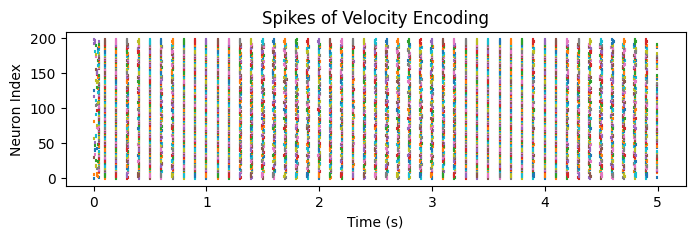

In [15]:
figure(figsize=(8,2))
V.spike_raster();
title('Spikes of Velocity Encoding');
#savefig('vel_spikes.pdf');

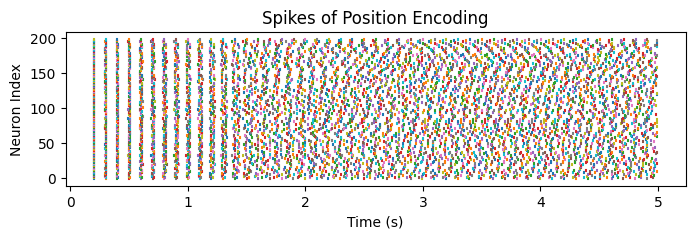

In [16]:
figure(figsize=(8,2))
y.spike_raster();
title('Spikes of Position Encoding');
#savefig('position_spikes.pdf');

### Resulting distance encoding

In [17]:
# Decode the value from population y for each cycle
fy, tvals = y.decode_xt(ds.S[0], [-5,5], [0, 5])

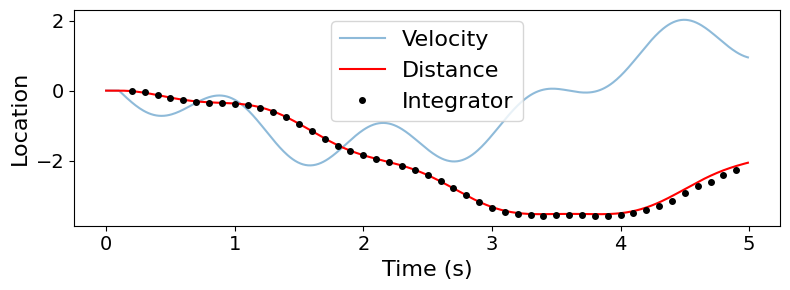

In [23]:
figure(figsize=(8,3))
plot(ttvals, vel(ttvals), alpha=0.5)
plot(ttvals, dist(vel, ttvals), 'r');
plot(tvals[2:], fy[2:], 'ko', ms=4);
legend(['Velocity', 'Distance', 'Integrator'], fontsize=16);#, loc=3);
xlabel('Time (s)', fontsize=16); ylabel('Location', fontsize=16);
gca().tick_params(axis='both', which='major', labelsize=14)
tight_layout();
savefig('integrator_results.pdf');